# 01_EASYREG coregistration of channels within each exam

Arvid Lundervold/Marianne Hannisdal

Last updated: **2025-03-13**





#### Kernel: segment-glioma (Python 3.11.9)


In [6]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import shutil
import subprocess as subp
import pathlib
import glob
import shutil
import string
from datetime import date
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython
from matplotlib.colors import ListedColormap
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from nilearn.masking import apply_mask
from nilearn.image.image import mean_img


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2025-03-13 18:01:37.189792: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:01:37.197391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 18:01:37.205730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 18:01:37.208210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 18:01:37.214838: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  0


I0000 00:00:1741885297.893943    5928 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-13 18:01:37.911157: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
os.environ['MKL_THREADING_LAYER'] = 'GNU'


In [9]:
!nvidia-smi

Thu Mar 13 18:03:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 3500 Ada Gene...    On  | 00000000:01:00.0 Off |                  Off |
| N/A   51C    P8              10W /  90W |     11MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
%env FREESURFER_HOME=/usr/local/freesurfer
%env FSL_HOME=/usr/local/fsl

env: FREESURFER_HOME=/usr/local/freesurfer
env: FSL_HOME=/usr/local/fsl


In [10]:
home = os.path.expanduser('~')

SITE = '10'
TREE = '/usr/bin/tree'

MRICONVERT = '/usr/local/freesurfer/bin/mri_convert'
FSLREORIENT2STD = '/usr/local/fsl/bin/fslreorient2std'
FLIRT = '/usr/local/fsl/bin/flirt'
FSLMATHS = '/usr/local/fsl/bin/fslmaths'
EASYREG = '/usr/local/freesurfer/bin/mri_easyreg'


base_dir = f'{home}/prj/glioma_recurrence/glioma_recurrence/data/{SITE}'
nifti_dir = f"{base_dir}/nifti_1"   
synthseg_dir = f"{base_dir}/synthseg"
segment_glioma_dir = f"{base_dir}/segment_glioma"
nifti_coreg_dir = f"{base_dir}/easyreg"


all_chns = ['T1', 'CT1', 'T2', 'FLAIR']
all_chns_synthseg = ['T1', 'CT1', 'T2', 'FLAIR', 'CT1_synthseg_parc_robust']
template = 'CT1'
inp_chns = [c for c in all_chns if c != template]  

# AD HOC colormap for HD-GLIO  (CE, NE)-segmentation overlay
# colors = [(1, 0, 0),  (0, 1, 0), (0, 0, 1)]  # R -> G -> B
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]  # R -> B -> G
n_bins = [2, 3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_cm'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[0])

In [11]:
# Execute tree command on the nifti subdirecory 
print(os.popen(f'{EASYREG} --help').read())

2025-03-13 18:04:44.324088: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:04:44.325198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:04:44.345546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:04:44.345760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 18:04:44.668436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

usage: mri_easyreg [-h] [--ref REF] [--ref_seg REF_SEG] [--flo FLO]
                   [--flo_seg FLO_SEG] [--ref_reg REF_REG] [--flo_reg FLO_REG]
                   [--fwd_field FWD_FIELD] [--bak_field BAK_FIELD]
                   [--affine_only] [--threads THREADS]

EasyReg: deep learning registration simple and easy

optional arguments:
  -h, --help            show this help message and exit
  --ref REF             Reference image .
  --ref_seg REF_SEG     Reference SynthSeg segmentation (will be created if it
                        does not exist).
  --flo FLO             Floating image.
  --flo_seg FLO_SEG     Floating SynthSeg segmentation (will be created if it
                        does not exist).
  --ref_reg REF_REG     (optional) Registered referenced.
  --flo_reg FLO_REG     (optional) Registetred floating images (in space of
                        reference).
  --fwd_field FWD_FIELD
                        (optional) Forward field
  --bak_field BAK_FIELD
             

### Get a list of all exams in `nifti_dir`

In [12]:
# Execute tree command on the nifti subdirecory 
print(os.popen(f'{TREE} {nifti_dir}').read())

/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1
└── 10_036_20150101
    ├── 10_036_20150101_CT1.nii.gz
    ├── 10_036_20150101_FLAIR.nii.gz
    ├── 10_036_20150101_T1.nii.gz
    └── 10_036_20150101_T2.nii.gz

1 directory, 4 files



In [13]:
cmd = [TREE, nifti_dir]
cmd_str = " ".join(cmd)

In [14]:
%%bash -s "$cmd_str"
$1

/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1
└── 10_036_20150101
    ├── 10_036_20150101_CT1.nii.gz
    ├── 10_036_20150101_FLAIR.nii.gz
    ├── 10_036_20150101_T1.nii.gz
    └── 10_036_20150101_T2.nii.gz

1 directory, 4 files


In [15]:
cmd = ['du', nifti_dir]
cmd_str = " ".join(cmd)

In [16]:
%%bash -s "$cmd_str"
$1 -hk --max-depth=2 | sort -k2

28792	/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1
28788	/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1/10_036_20150101


# Make helper functions

### Get image matrices and voxel resolutions for each channel

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
def get_shape_res(base, exam):
    
    fnbase = f"{base}/{exam}/{exam}"
    T1fn = f"{fnbase}_T1.nii.gz"                                 # T1.nii.gz
    CT1fn = f"{fnbase}_CT1.nii.gz"                               # CT1.nii.gz
    T2fn = f"{fnbase}_T2.nii.gz"                                 # T2.nii.gz
    FLAIRfn = f"{fnbase}_FLAIR.nii.gz"                           # FLAIR.nii.gz
    
    chns = [T1fn, CT1fn, T2fn, FLAIRfn]
        
    print(f"\nexam: {exam}")
    for i, c in enumerate(chns):
        print(f" chn{i}: {c}")
        img = nib.load(c)
        print(f"   shape: {img.shape}, voxels: {img.header.get_zooms()}")


In [20]:
exams_list = sorted([x for x in next(os.walk(nifti_dir))[1]])
exams_list

['10_036_20150101']

### Coregister all channels to the CT1 space

See **EsyReg** (https://surfer.nmr.mgh.harvard.edu/fswiki/EasyReg) for a deep learning-based method

**EasyReg** makes deep learning registration of brain MRI easy to use, while exhibiting the best features of classical and deep learning registration tools:

- No preprocessing is needed (e.g., skull stripping, bias field correction, affine registration to template).
- Does affine and nonlinear registration.
- Registration is diffeomorphic and invertible (forward and backward fields are provided).
- The method is symmetric: if you switch the order of the inputs, your forward field will be equal to your backward field if you had not switched the order (and vice versa).
- It handles MRI scans of any orientation (sagittal/coronal/axial), resolution, and modality (T1, T2, FLAIR, etc).
- Reference and floating images can be of different orientation, resolution, and modality.
- It has no parameters to tune.
- It is fast (about one minute on a modern CPU).

Refs:<br>

- Iglesias, J.E. A ready-to-use machine learning tool for symmetric multi-modality registration of brain MRI. Sci Rep 13, 6657 (2023). https://doi.org/10.1038/s41598-023-33781-0

- M. Hoffmann, B. Billot, D. N. Greve, J. E. Iglesias, B. Fischl and A. V. Dalca, "SynthMorph: Learning Contrast-Invariant Registration Without Acquired Images," in IEEE Transactions on Medical Imaging, vol. 41, no. 3, pp. 543-558, March 2022,<br> https://doi.org/10.1109/TMI.2021.3116879. <br>keywords: {Training;Magnetic resonance imaging;Strain;Three-dimensional displays;Shape;Neuroimaging;Measurement;Deformable image registration;data independence;deep learning;MRI-contrast invariance},


#### Usage

```bash
mri_easyreg --ref <reference_image> --flo <floating_image>  \
            --ref_seg <ref_image_segmentation> --flo_seg <flo_image_segmentation>  \
            --ref_reg [deformed_ref_image] --flo_reg <deformed_flo_image>  \
            --fwd_field [forward_field] --bak_field <backward_field>  \
            --threads <number_of_threads> --affine_only
```

where

```bash
<reference_image>: (required) the reference image in .nii(.gz) or .mgz format (note that, since the method is symmetric, the choice of reference vs floating is arbitrary).

<floating_image>: (required) the floating image.

<ref_image_segmentation>: (required) file with the SynthSeg v2 (non-robust) segmentation + parcellation of the reference image. If it does not exist, EasyReg will create it. If it already exists (e.g., from a previous EasyReg run), then EasyReg will read it from disk (which is faster than segmenting).

<flo_image_segmentation>: (required) same for floating image.

<deformed_ref_image>: (optional) this is the file where the deformed (registered) reference image is written.

<deformed_flo_image>: (optional) this is the file where the deformed (registered) floating image is written.

<forward_field>: (optional) this is the file where the forward deformation field is written. The deformation includes both the affine and nonlinear components. Must be a nifti (.nii/.nii.gz) or .mgz file; it is encoded as the real world (RAS) coordinates of the target location for each voxel.

<backward_field>: (optional) this is the file where the backward deformation field is written. It must also be a nifty or mgz file.

<threads>: (optional) Number of threads to use. Set to -1 to use the maximum (i.e., the total number of available cores). Note that the default is 1, which will run much more slowly.

--affine_only: (optional) Use this flag to skip the nonlinear registration estimated by the neural network (i.e., do affine only).
```




In [21]:
# Run EasyReg on all channels of a given exam with CT1 as the reference channel 

def easyreg(exam, chns, ref_chn, nifti_dir, nifti_coreg_dir, synthseg_dir):

    # Create the output directory for the coregistered images
    exam_dir = f"{nifti_coreg_dir}/{exam}"
    if not os.path.exists(exam_dir):
        os.makedirs(exam_dir)
    ref_seg_dir = f"{synthseg_dir}/{exam}"    

    # Copy the reference channel to the output directory
    ref_chn_fn = f"{nifti_dir}/{exam}/{exam}_{ref_chn}.nii.gz"
    ref_chn_coreg_fn = f"{exam_dir}/{exam}_{ref_chn}_coreg.nii.gz"
    shutil.copy(ref_chn_fn, ref_chn_coreg_fn)

    # Run EasyReg on all channels of the exam with CT1 as the reference channel
    for chn in chns:
        chn_fn = f"{nifti_dir}/{exam}/{exam}_{chn}.nii.gz"
        chn_coreg_fn = f"{exam_dir}/{exam}_{chn}_coreg.nii.gz"
        
        cmd = [EASYREG,  '--ref',ref_chn_coreg_fn, '--flo', chn_fn, '--flo_reg', chn_coreg_fn, '--ref_seg', ref_image_segmentation, '--flo_seg', flo_image_segmentation,'--threads', '10', '--affine_only']
        print(cmd)

        subp.run(cmd)

In [22]:
# Run easyreg on all channels of a given exam with CT1 as the reference channel

for ex in exams_list:   # [0:1]:
    print(ex)
    print(inp_chns)
    print(template)
    print(nifti_dir)
    print(nifti_coreg_dir)
    
    easyreg(exam=ex, chns=inp_chns, ref_chn=template, nifti_dir=nifti_dir, nifti_coreg_dir=nifti_coreg_dir)



10_036_20150101
['T1', 'T2', 'FLAIR']
CT1
/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1
/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/easyreg
/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/synthseg
['/usr/local/freesurfer/bin/mri_easyreg', '--ref', '/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/easyreg/10_036_20150101/10_036_20150101_CT1_coreg.nii.gz', '--flo', '/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/nifti_1/10_036_20150101/10_036_20150101_T1.nii.gz', '--flo_reg', '/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/easyreg/10_036_20150101/10_036_20150101_T1_coreg.nii.gz', '--ref_seg', '/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/synthseg/10_036_20150101/10_036_20150101_CT1_synthseg_parc_robust.nii.gz', '--flo_seg', '/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/synthseg/10_036_20150101/10_036_20150101_T1_synthseg_parc_robust.nii.gz', '--thre

2025-03-13 18:06:21.487828: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:06:21.488937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:21.509534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:21.509787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 18:06:21.822084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

using 10 threads
Segmentation of reference image already exists; reading from disk
Segmentation of floating image already exists; reading from disk
Linear registration
  Computing centroids and estimating affine transform
  Reading reference image
  Deforming reference image to reference space
  Deforming reference segmentation to reference space
  Normalizing intensities of reference image
  Reading floating image
  Deforming floating image to reference space
  Deforming floating segmentation to reference space
  Normalizing intensities of floating image
Skipping nonlinear registration
Deforming and writing to disk
  Computing forward field
  Deforming floating image
  Saving deformed floating image
All done
 
If you use EasyReg in your analysis, please cite:
A ready-to-use machine learning tool for symmetric multi-modality registration of brain MRI.
JE Iglesias. Scientific Reports, accepted for publication.
https://www.nature.com/articles/s41598-023-33781-0
 
['/usr/local/freesurfer/

2025-03-13 18:06:29.922865: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:06:29.923979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:29.944479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:29.944750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 18:06:30.262603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

using 10 threads
Segmentation of reference image already exists; reading from disk
Segmentation of floating image already exists; reading from disk
Linear registration
  Computing centroids and estimating affine transform
  Reading reference image
  Deforming reference image to reference space
  Deforming reference segmentation to reference space
  Normalizing intensities of reference image
  Reading floating image
  Deforming floating image to reference space
  Deforming floating segmentation to reference space
  Normalizing intensities of floating image
Skipping nonlinear registration
Deforming and writing to disk
  Computing forward field
  Deforming floating image
  Saving deformed floating image
All done
 
If you use EasyReg in your analysis, please cite:
A ready-to-use machine learning tool for symmetric multi-modality registration of brain MRI.
JE Iglesias. Scientific Reports, accepted for publication.
https://www.nature.com/articles/s41598-023-33781-0
 
['/usr/local/freesurfer/

2025-03-13 18:06:38.384949: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:06:38.386032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:38.406758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:06:38.406997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 18:06:38.731775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

using 10 threads
Segmentation of reference image already exists; reading from disk
Segmentation of floating image already exists; reading from disk
Linear registration
  Computing centroids and estimating affine transform
  Reading reference image
  Deforming reference image to reference space
  Deforming reference segmentation to reference space
  Normalizing intensities of reference image
  Reading floating image
  Deforming floating image to reference space
  Deforming floating segmentation to reference space
  Normalizing intensities of floating image
Skipping nonlinear registration
Deforming and writing to disk
  Computing forward field
  Deforming floating image
  Saving deformed floating image
All done
 
If you use EasyReg in your analysis, please cite:
A ready-to-use machine learning tool for symmetric multi-modality registration of brain MRI.
JE Iglesias. Scientific Reports, accepted for publication.
https://www.nature.com/articles/s41598-023-33781-0
 



### Visualize the coregistered images

In [41]:
#res_dir = nifti_dir
nifti_coreg_dir = f"{base_dir}/easyreg"

x, y, z = -80, -90, 35   # Cursor RAS from freeview display (Freesurfer)

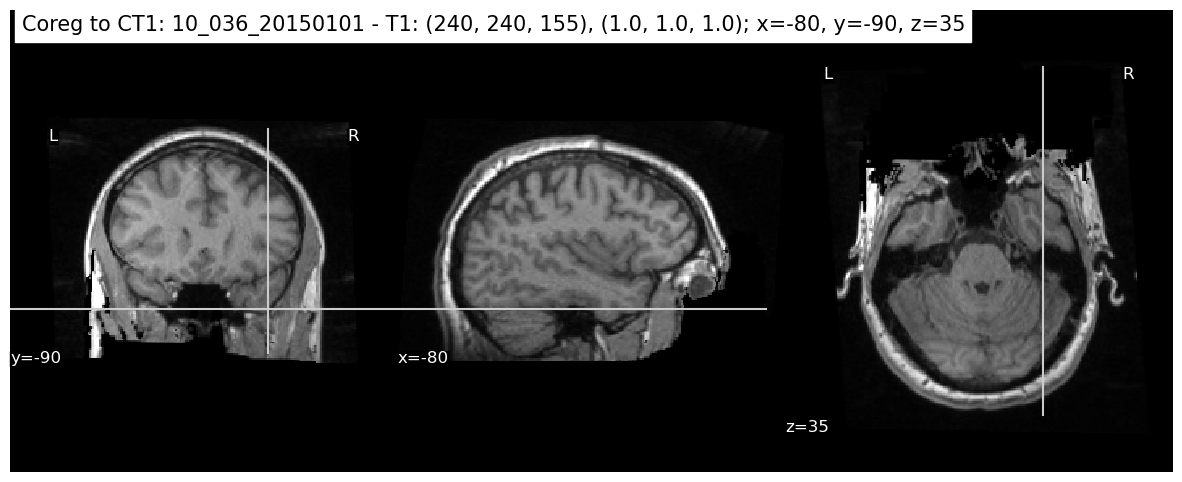

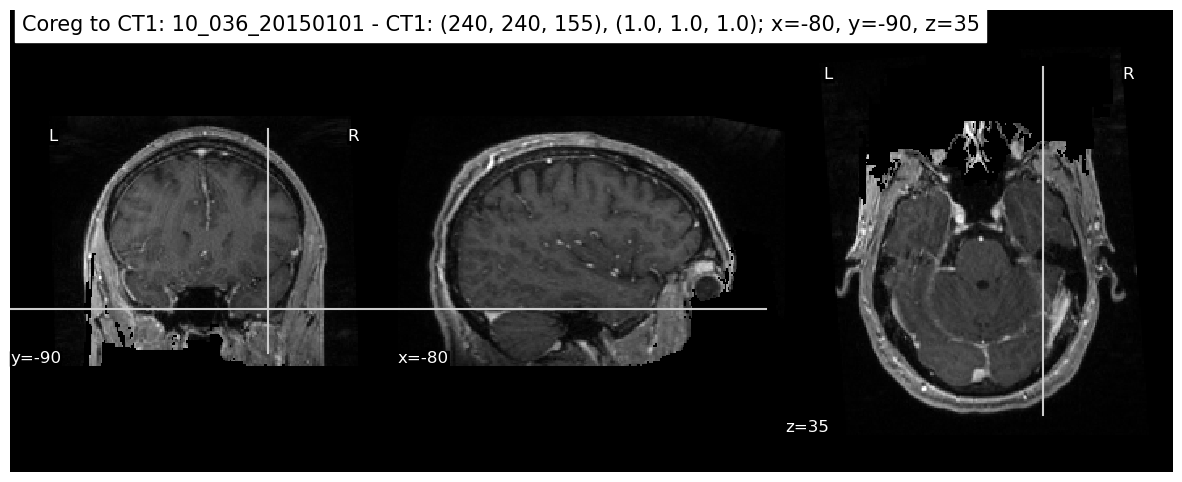

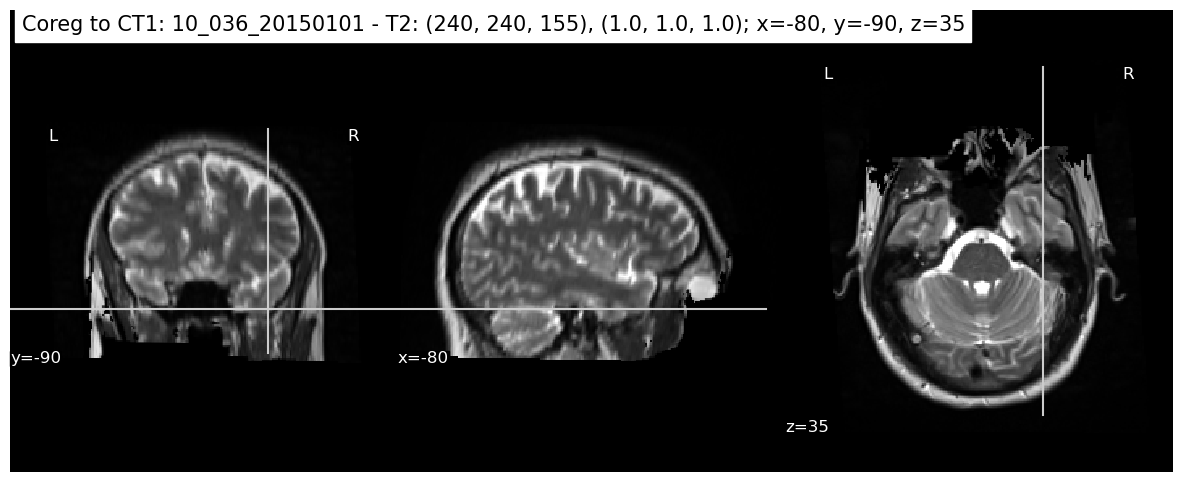

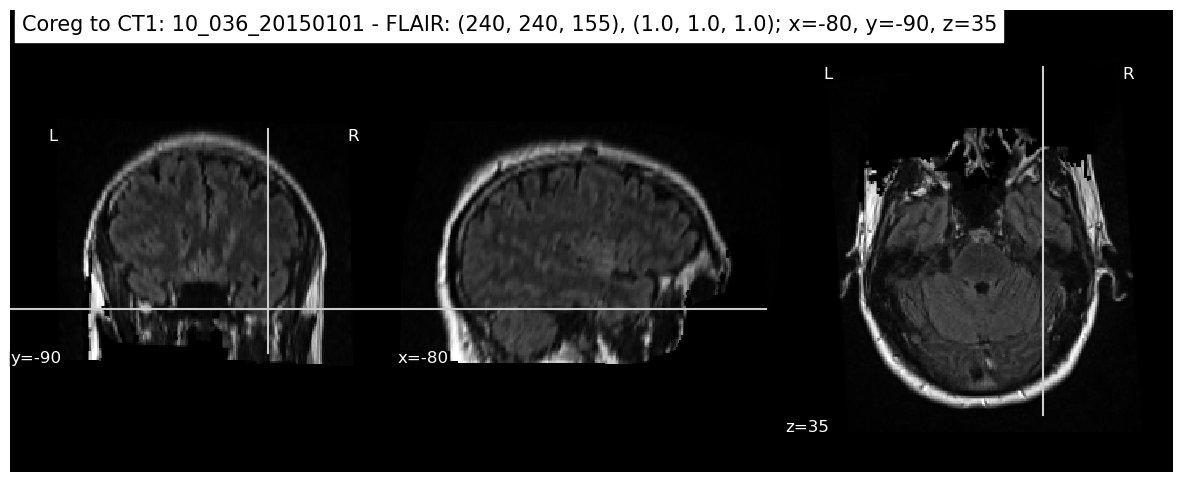

CPU times: user 3.09 s, sys: 139 ms, total: 3.23 s
Wall time: 3.23 s


In [44]:
%%time
for exam in [f'10_036_20150101' for i in range(1)]:
    for i, chn in enumerate(all_chns):
        fn_inp = f'{nifti_coreg_dir}/{exam}/{exam}_{chn}_coreg.nii.gz'
        img = nib.load(fn_inp)
        # OrthoSlicer3D(img.get_fdata(), affine= img.affine, title=template).show()
        fig, ax  = plt.subplots(1, 1, figsize=(15,6))
        title = f'Coreg to CT1: {exam} - {chn}: {img.shape}, {img.header.get_zooms()}; x={x}, y={y}, z={z}'
        plotting.plot_anat(img, axes = ax, title=title, cmap="gray", dim= -0.7, cut_coords = (x, y, z))
        plt.show()